# EXAMPLE 1: Correct and display

This example covers the basic usage of the dual-PRF velocity correction function:

- [Load raw data with Py-ART](#load_data_pyart)  
- [Apply the correction function](#apply_vcor)  
- [Display the results](#display)


**EVENT**: A tornado associated to a rotating cell that took place near Cardona town (41º54'51'' N, 1º40'52'' E) on the 7th of January 2018.

**DATA**: It works with data from the weather radar network (XRAD) of the Meteorological Service of Catalonia. This data is in IRIS RAW format. In this particular case, the data used is from Creu del Vent (CDV) radar.

**LIBRARIES/FUNCTIONS:**

In [1]:
import pyart
import vcor_dual_prf as vcor

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



**RADAR SETTINGS:**

Input file, elevation/sweep number

In [2]:
file_in = '../sample_data/CDV180107_tornado.RAW'
sw = 3

**DISPLAY SETTINGS**

Site coordinates (decimal lat/lon), display region limits (decimal lat/lon), tick locations

In [3]:
ylim = (-40, 60)
xlim = (-25, 75)
range_rings = range(25, 150, 25)

Set a custom colormap for the velocity

In [4]:
cmaplst_l = [plt.get_cmap('ocean', 22)(i) for i in list(range(1, 22))] + [plt.get_cmap('gnuplot_r', 30)(i) for i in list(range(1, 21))]
cmap_vel = mpl.colors.ListedColormap(cmaplst_l)
cmap_vel.set_bad('lightgrey', 1.)

<a id='load_data_pyart'></a>
### Load raw data with Py-ART

Py-ART reads the data and metadata in the input file into a dictionary structure (radar object instance):

In [5]:
rad = pyart.io.read(file_in)

Let's check the data fields that have been loaded:

In [6]:
rad.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity'])

For plotting purposes only, we retrieve the Nyquist velocity stored in the radar instance metadata :

In [7]:
# Nyquist velocity
v_ny = rad.instrument_parameters['nyquist_velocity']['data'][0]
v_ny

39.975

<a id='apply_vcor'></a>
### Apply the correction function

As a first example, we apply the correction function for all 4 the methods available. 

The function parameters specified in each case correspond (as precisely as possible) to the ones detailed in the original publications. When a parameter is not explicitly mentioned in the publication, we leave the one set by default in the function. 

Application of the function includes the addition of a new data field in the radar instance. 


**(a) 'mean' method**: 

Joe, P. and May, P. T., 2003: Correction of dual PRF velocity errors for operational Doppler weather radars. *J. Atmos. Oceanic Technol.*, 20(4), 429-442

In [8]:
vcor.correct_dualprf(radar=rad, two_step=False, 
                     method_det='mean', kernel_det=np.ones((3, 3)),
                     vel_field='velocity', new_field='vcor_mean')

/scratch/en0/jss548/miniforge3/envs/dwd/lib/python3.12/site-packages/vcor_dual_prf-1.0.0-py3.12.egg/vcor_dual_prf/vcor_dual_prf.py:263: RuntimeWarning: invalid value encountered in divide


**(b) 'median' method**:

Holleman, I. and Beekhuis, H., 2003: Analysis and correction of dual PRF velocity data. *J. Atmos. Oceanic Technol.*, 20(4), 443-453 

In [9]:
vcor.correct_dualprf(radar=rad, two_step=False, 
                     method_det='median', kernel_det=np.ones((3, 3)), 
                     vel_field='velocity', new_field='vcor_median')

/scratch/en0/jss548/miniforge3/envs/dwd/lib/python3.12/site-packages/scipy/ndimage/_filters.py:1856: RuntimeWarning: All-NaN slice encountered
  _nd_image.generic_filter(input, function, footprint, output, mode,


**(c) 'cmean_sc' method**: 

Altube, P., et al., 2017: Correction of dual-PRF Doppler velocity outliers in the presence of aliasing. *J. Atmos. Oceanic Technol.*, 34(7), 1529-1543 

In [10]:
vcor.correct_dualprf(radar=rad, two_step=True, 
                     method_det='cmean_sc', kernel_det=np.ones((7, 7)),
                     method_cor='median', kernel_cor=np.ones((7, 7)),
                     vel_field='velocity', new_field='vcor_cmean_sc')

**(d) 'cmean' method**: Hengstebeck, T., et al., 2018: Radar network–based detection of mesocyclones at the German
Weather Service. *J. Atmos. Oceanic Technol.*, 35(2), 299-321

In [11]:
vcor.correct_dualprf(radar=rad, two_step=True,
                     method_det='cmean', kernel_det=np.ones((11, 11)),
                     method_cor='cmean', kernel_cor=np.ones((5, 5)),
                     vel_field='velocity', new_field='vcor_cmean')

Let's check that all the corrections have been stored in the radar instance:

In [12]:
rad.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'vcor_mean', 'vcor_median', 'vcor_cmean_sc', 'vcor_cmean'])

In [23]:
radar = rad
sw = 0
sweep_start = radar.get_start(0)
print('sweep', sw, radar.fixed_angle['data'][sw])
print('ni', radar.instrument_parameters['nyquist_velocity']['data'][sweep_start:sweep_start+3])
print('prt', radar.instrument_parameters['prt']['data'][sweep_start:sweep_start+3])
print('prt_ratio', radar.instrument_parameters['prt_ratio']['data'][sweep_start:sweep_start+3])
print('prt_mode', radar.instrument_parameters['prt_mode']['data'][sw])
print('prf_flag', radar.instrument_parameters['prf_flag']['data'][sweep_start:sweep_start+3])
print('')

print(radar.fields['velocity']['data'])

sweep 0 0.5987549
ni [39.975 39.975 39.975]
prt [0.001 0.001 0.001]
prt_ratio [1.3333334 1.3333334 1.3333334]
prt_mode b'dual'
prf_flag [1 0 1]

[[6.610039234161377 7.239567279815674 8.498621940612793 ... -- -- --]
 [6.610039234161377 7.869094371795654 9.442914009094238 ... -- -- --]
 [6.610039234161377 8.498621940612793 8.498621940612793 ... -- -- --]
 ...
 [6.924803256988525 10.072441101074219 10.38720417022705 ... -- -- --]
 [6.924803256988525 9.128149032592773 11.016732215881348 ... -- -- --]
 [8.183858871459961 10.38720417022705 10.7019681930542 ... -- -- --]]


<a id='display'></a>
### Display the results

(-40.0, 60.0)

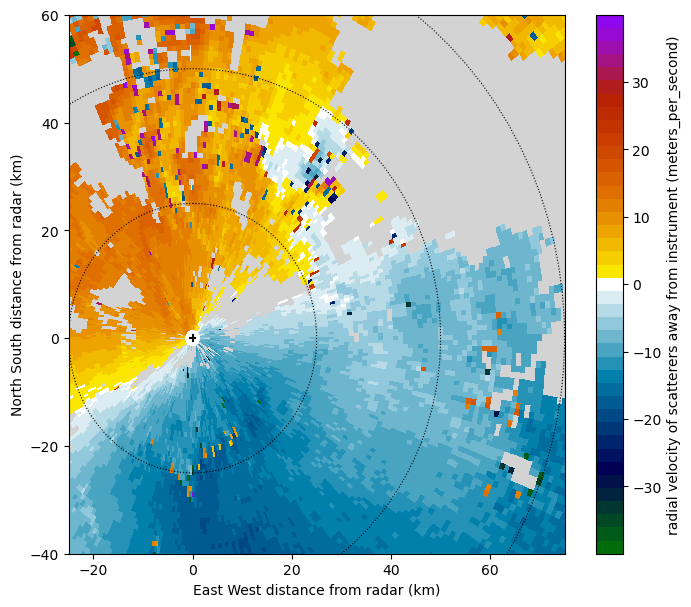

In [13]:
display = pyart.graph.RadarDisplay(rad)
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)

display.plot('velocity', sw, ax=ax, vmin=-v_ny, vmax=v_ny, mask_outside=False, 
             cmap=cmap_vel, colorbar_flag=True, title_flag=False)
display.plot_range_rings(range_rings, lw=0.8, ls=':', ax=ax)
display.plot_cross_hair(0.5, ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

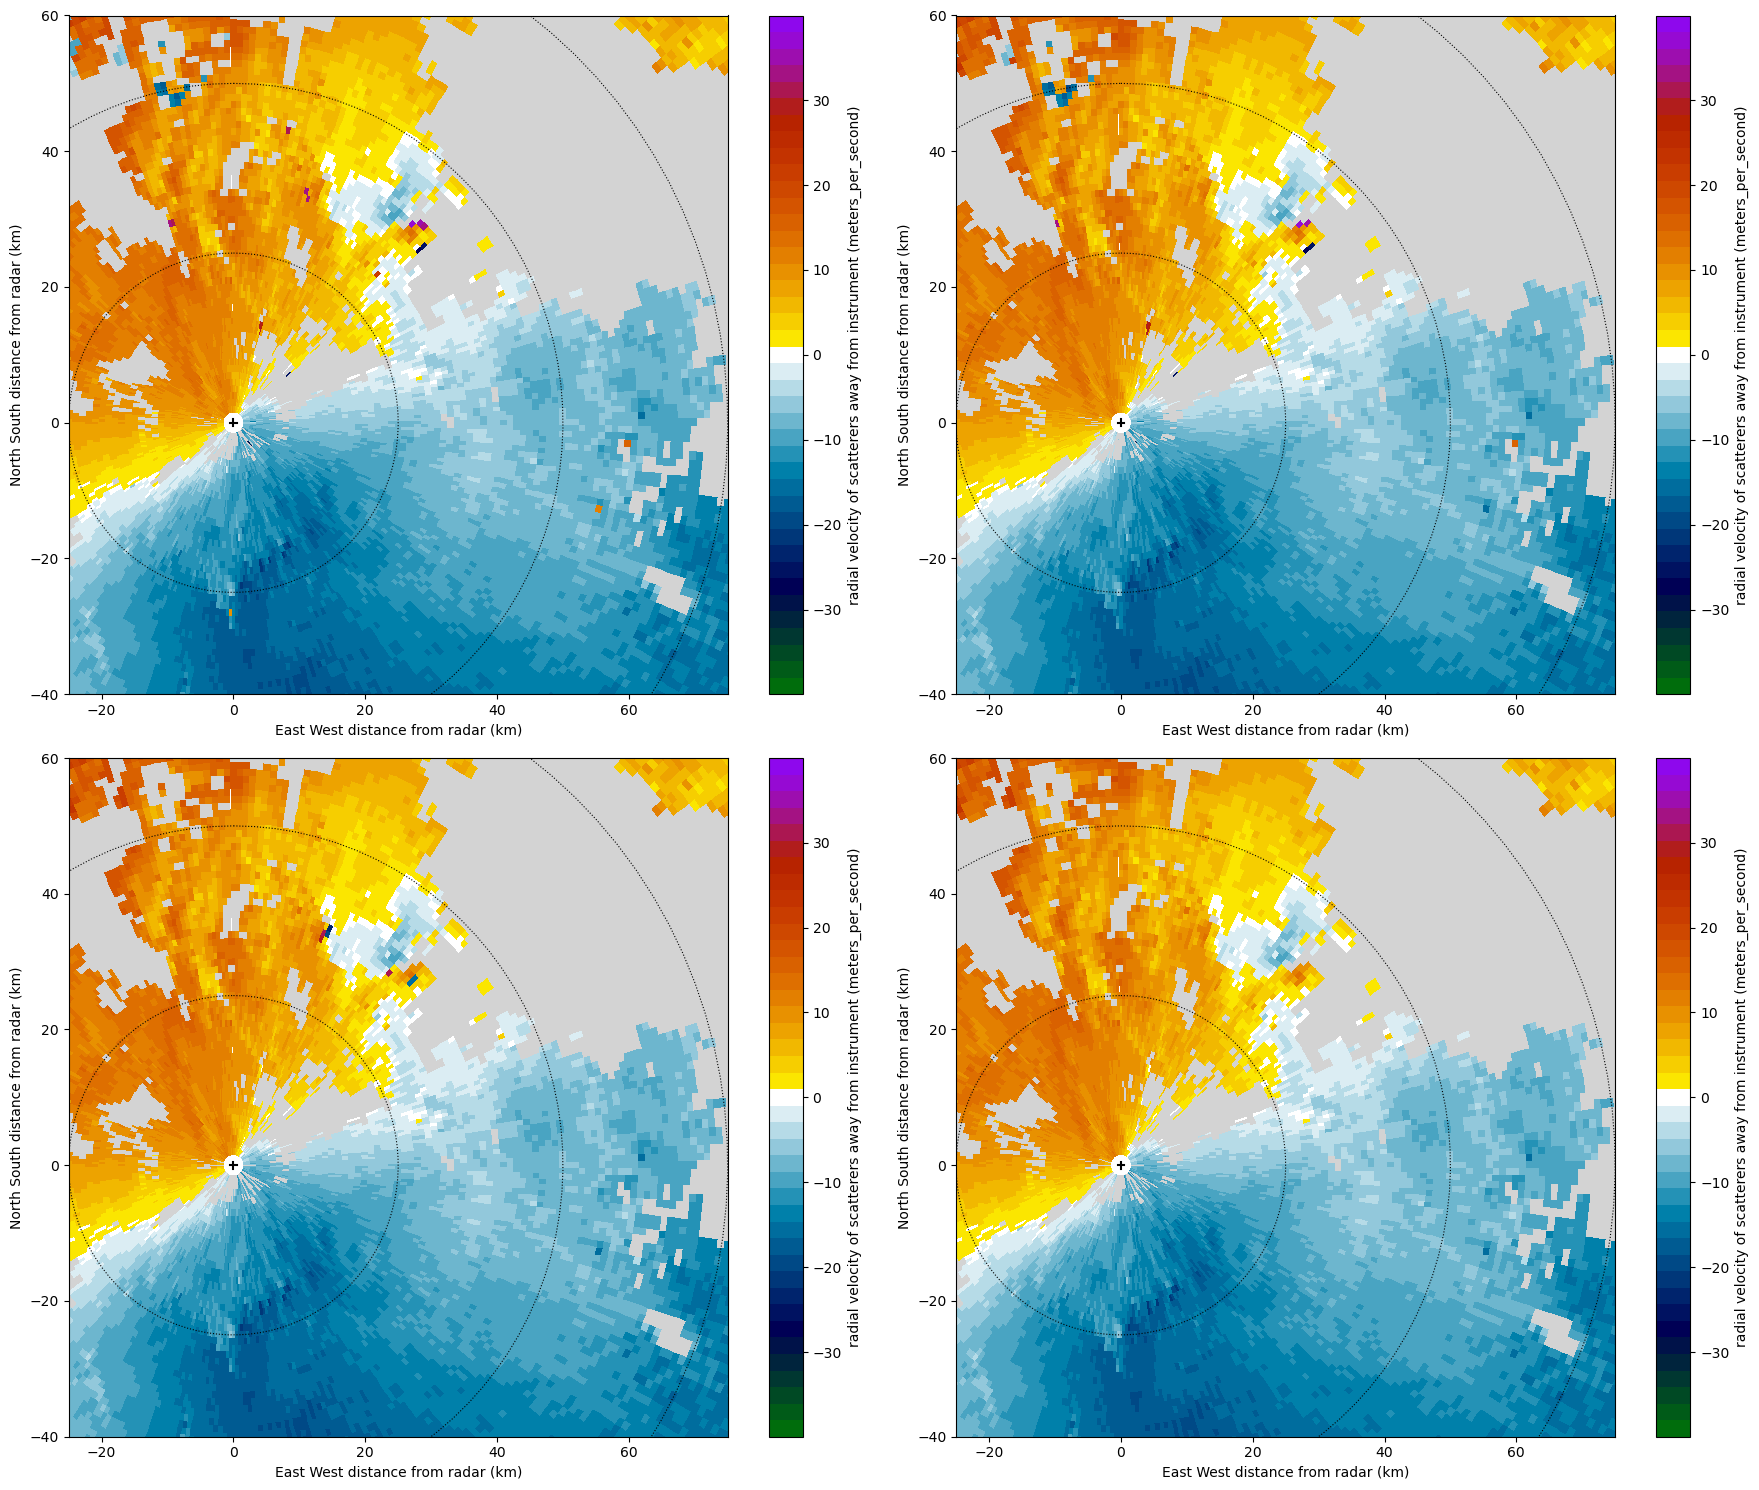

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,15))

display.plot('vcor_mean', sw, ax=ax1, vmin=-v_ny, vmax=v_ny, mask_outside=False, 
             cmap=cmap_vel, colorbar_flag=True, title_flag=False)
display.plot_range_rings(range_rings, lw=0.8, ls=':', ax=ax1)
display.plot_cross_hair(0.5, ax=ax1)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

display.plot('vcor_median', sw, ax=ax2, vmin=-v_ny, vmax=v_ny, mask_outside=False, 
            cmap=cmap_vel, colorbar_flag=True, title_flag=False)
display.plot_range_rings(range_rings, lw=0.8, ls=':', ax=ax2)
display.plot_cross_hair(0.5, ax=ax2)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

display.plot('vcor_cmean_sc', sw, ax=ax3, vmin=-v_ny, vmax=v_ny, mask_outside=False, 
            cmap=cmap_vel, colorbar_flag=True, title_flag=False)
display.plot_range_rings(range_rings, lw=0.8, ls=':', ax=ax3)
display.plot_cross_hair(0.5, ax=ax3)
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

display.plot('vcor_cmean', sw, ax=ax4, vmin=-v_ny, vmax=v_ny, mask_outside=False, 
            cmap=cmap_vel, colorbar_flag=True, title_flag=False)
display.plot_range_rings(range_rings, lw=0.8, ls=':', ax=ax4)
display.plot_cross_hair(0.5, ax=ax4)
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)

fig.tight_layout()
plt.show()